## Importation des librairies

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style

# Use the updated seaborn style name with the version prefix (v0_8)
plt.style.use('seaborn-v0_8-white')

from tensorflow.keras.utils import plot_model
import random
from PIL import Image
import glob
import seaborn as sns
from tqdm.notebook import tqdm
import time

from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve,auc, accuracy_score, confusion_matrix, classification_report

import tensorflow
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

## Chargement des donnees

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
train_path = "/content/drive/MyDrive/Training"
test_path = "/content/drive/MyDrive/Testing"

classes = ['no_tumor','pituitary_tumor', 'meningioma_tumor','glioma_tumor']

X_train = []
Y_train = []

# Fonction pour charger les images et attribuer une classe
def load_data(directory):
    for class_name in tqdm(os.listdir(directory),desc=directory):
        # Only process folders that are in the 'classes' list
        if class_name in classes:
            class_path = os.path.join(directory, class_name)
            class_label = class_name
            for image_name in os.listdir(class_path):
                image_path = os.path.join(class_path, image_name)
                img = cv2.imread(image_path)
                X_train.append(img)
                Y_train.append(classes.index(class_name))
    return X_train,Y_train

X_train , Y_train = load_data(train_path)
X_train , Y_train = load_data(test_path)

/content/drive/MyDrive/Training:   0%|          | 0/5 [00:00<?, ?it/s]

/content/drive/MyDrive/Testing:   0%|          | 0/4 [00:00<?, ?it/s]

## Visualisation des donnees

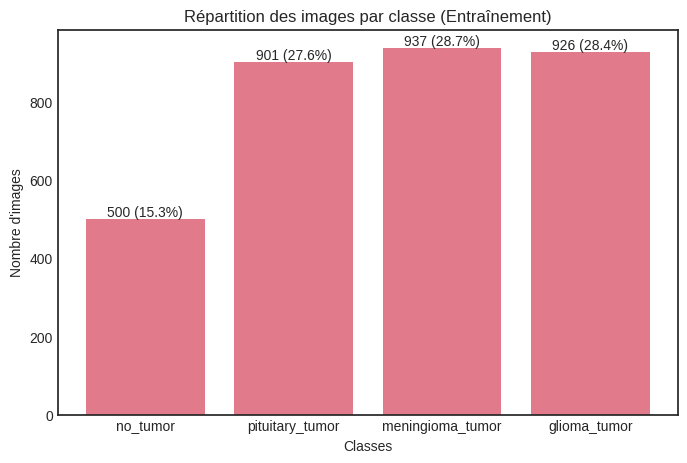

In [ ]:
# Fonction pour compter le nombre d'images par classe
def count_images_per_class(data, classes):
    count_per_class = {class_name: 0 for class_name in classes}
    for class_idx in data:
        class_name = classes[class_idx]
        count_per_class[class_name] += 1
    return count_per_class

# Compter le nombre d'images par classe pour l'ensemble d'entraînement et de test
train_count_per_class = count_images_per_class(Y_train, classes)

plt.figure(figsize=(8, 5))
#train  data
train_bars = plt.bar(train_count_per_class.keys(), train_count_per_class.values(), color='#E17A8A')
plt.title('Répartition des images par classe (Entraînement)')
plt.xlabel('Classes')
plt.ylabel('Nombre d\'images')

# ajouter les pourcentages
for bar in train_bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height} ({height / np.sum(list(train_count_per_class.values())) * 100:.1f}%)', ha='center', va='bottom', fontsize=10)

plt.show()

## Quelques exemples d'images pour chaque classe

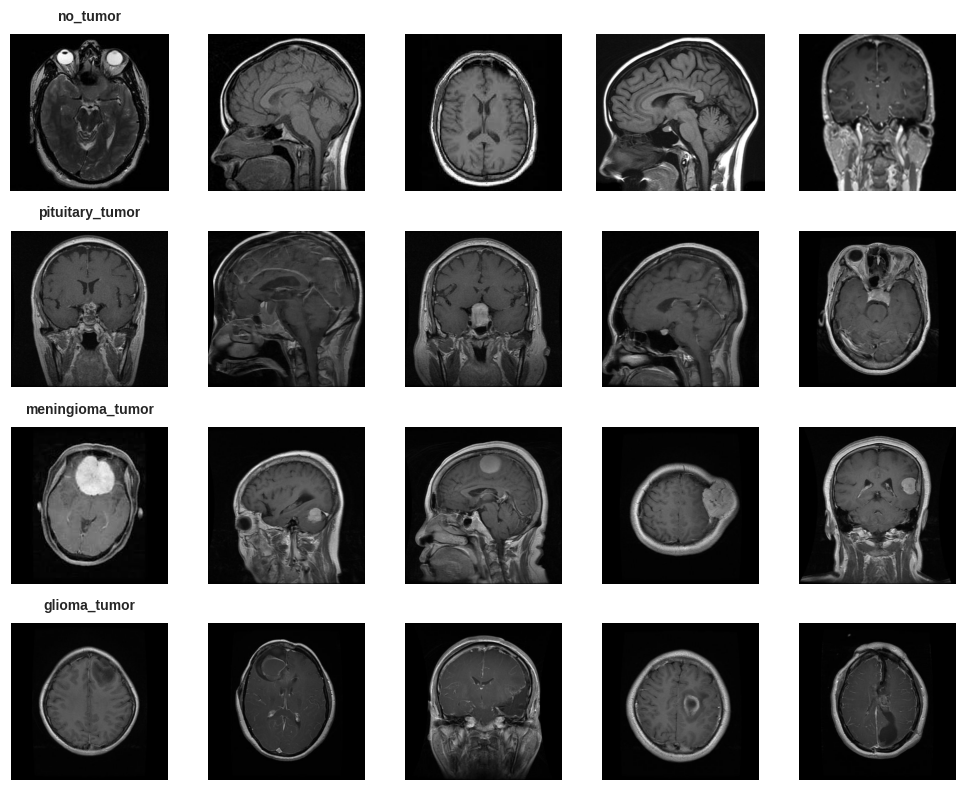

In [ ]:
def show_examples(X_data, Y_data, classes, num_examples=5):
    num_classes = len(classes)
    fig, axs = plt.subplots(num_classes, num_examples, figsize=(10, 8))

    for i, class_name in enumerate(classes):
        class_indices = [idx for idx, label in enumerate(Y_data) if label == i]
        axs[i, 0].set_title(class_name, fontsize=10, pad=10, fontweight='bold')
        for j in range(num_examples):
                img = X_data[class_indices[j]]
                axs[i, j].imshow(img)
                axs[i, j].axis('off')

    plt.tight_layout()
    plt.show()

# Afficher des exemples d'images pour chaque classe
show_examples(X_train, Y_train, classes)

### La taille la plus fréquente

In [ ]:
#tailles des images les plus fréquentes :
train_data_shapes = []
for img in X_train:
  train_data_shapes.append(img.shape)
# Compter les occurrences pour chaque taille
shape_counts = {}
for shape in train_data_shapes:
  if shape not in shape_counts:
    shape_counts[shape] = 0
  shape_counts[shape] += 1
# Trier les formes par nombre
sorted_shapes = sorted(shape_counts.items(), key=lambda x: x[1], reverse=True)
# afficher la taille la plus fréquente
print("Most frequent Train images shapes:")
for shape, count in sorted_shapes[:3]:
  print(f"- {shape}: {count}")

Most frequent Train images shapes:
- (512, 512, 3): 2341
- (236, 236, 3): 79
- (225, 225, 3): 43


La plupart des images présentent une haute résolution de 512x512 pixels. Cette résolution élevée peut entraîner des temps de traitement plus longs et une consommation de mémoire plus importante. Par conséquent, pour optimiser les performances du modèle tout en conservant une qualité d'image adéquate, une résolution moins élevée de 225x225 pixels est préférée

In [ ]:
shape = (225, 225, 3)

## Preparation des donnees

In [ ]:
# fonction qui permet de recadrez une image
def crop_image(image):
    # Convertir l'image en niveaux de gris
    if len(image.shape) == 3:  # Vérifiez si l'image est au format BGR
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:  # L'image est déjà en niveaux de gris
        gray = image.copy()

    # Threshold l'image
    _, thresh = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)

    # Rechercher les contours dans l'image
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Trouver le plus grand contour
    largest_contour = max(contours, key=cv2.contourArea)

    # Recadrez l'image au plus grand contour
    cropped_image = image[cv2.boundingRect(largest_contour)[1]:cv2.boundingRect(largest_contour)[1] + cv2.boundingRect(largest_contour)[3], cv2.boundingRect(largest_contour)[0]:cv2.boundingRect(largest_contour)[0] + cv2.boundingRect(largest_contour)[2]]

    return cropped_image

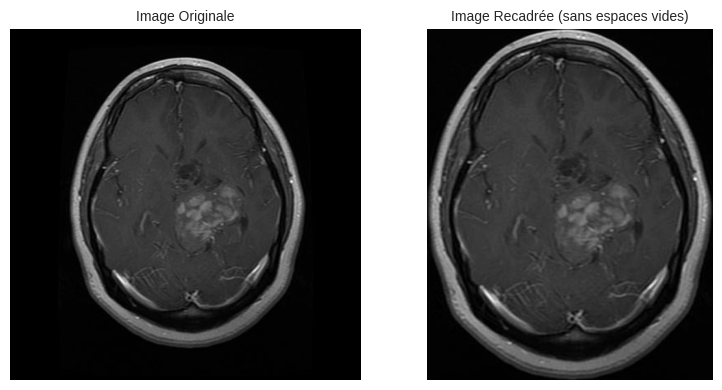

In [ ]:
image_path = "/content/drive/MyDrive/Training/glioma_tumor/gg (1).jpg"
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Check if the image was loaded successfully
if img is None:
    print(f"Error: Could not load image from {image_path}. Please check the file path.")
else:
    # Charger et recadrer l'image
    cropped_image = crop_image(img)

    # Afficher l'image originale et l'image recadrée
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.imread(image_path, cv2.IMREAD_GRAYSCALE), cmap='gray')
    plt.title("Image Originale", fontsize=10)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(cropped_image, cmap='gray')
    plt.title("Image Recadrée (sans espaces vides)", fontsize=10)
    plt.axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
#recadrer, normaliser et redimensionner toutes les images
def preprocess_data(train_data):
  processed_data = []
  for img in tqdm(train_data):

    # Appliquer le recadrage
    cropped_img = crop_image(img)

    # Redimensionner l'image
    resized_img = cv2.resize(cropped_img, (shape[1], shape[0]))

    # Normaliser l'image
    #normalized_img = resized_img / 255.0
    normalized_img = cv2.normalize(resized_img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

    # Ajouter l'image prétraitée et le nom de la classe aux données traitées
    processed_data.append(normalized_img)

  return processed_data
# Prétraiter les données d'entraînement et de test
X_train = preprocess_data(X_train)

X_train = np.array(X_train)

  0%|          | 0/3264 [00:00<?, ?it/s]

Avant de procéder à l'entraînement du modele, plusieurs étapes de prétraitement des données sont nécessaires pour garantir la qualité et la cohérence des données d'entrée :


*   **recadrage**: Le recadrage d'images est crucial dans la préparation des données de l'imagerie par résonance magnétique (IRM), car il permet d'éliminer les espaces vides et de se concentrer uniquement sur la région d'intérêt, c'est-à-dire la zone contenant la tumeur et les structures anatomiques pertinentes. En éliminant les espaces vides, le recadrage réduit la quantité de données inutiles et concentre l'analyse sur les caractéristiques pertinentes, améliorant ainsi l'efficacité des algorithmes de détection et de classification des tumeurs cérébrales.
*   **redimensionnement** : Le redimensionnement des images est essentiel, car il permet d'assurer la cohérence de la taille des images et facilite ainsi le traitement informatique. Il garantit que les données sont compatibles avec les exigences des modèles d'apprentissage automatique et des algorithmes de traitement d'images. De plus, le redimensionnement peut contribuer à prévenir les problèmes de surcharge de mémoire et d'optimiser les performances des modèles en permettant une manipulation efficace des données.

*   **normalisation** : La normalisation des données consiste à mettre à l'échelle les valeurs des caractéristiques d'un ensemble de données pour qu'elles se situent dans une plage spécifique ou aient une distribution spécifique. La fonction normalize() de la bibliothèque OpenCV est utilisée pour normaliser une image ou un tableau multidimensionnel, en spécifiant la plage de valeurs souhaitée et le type de normalisation. La méthode NORM_MINMAX est l'une des techniques de normalisation les plus couramment utilisées. Elle normalise les valeurs des pixels d'une image de manière à ce qu'elles soient ramenées à une plage spécifiée, généralement allant de 0 à 1 ou de 0 à 255. (alpha peut être réglé sur 0 et beta sur 1)





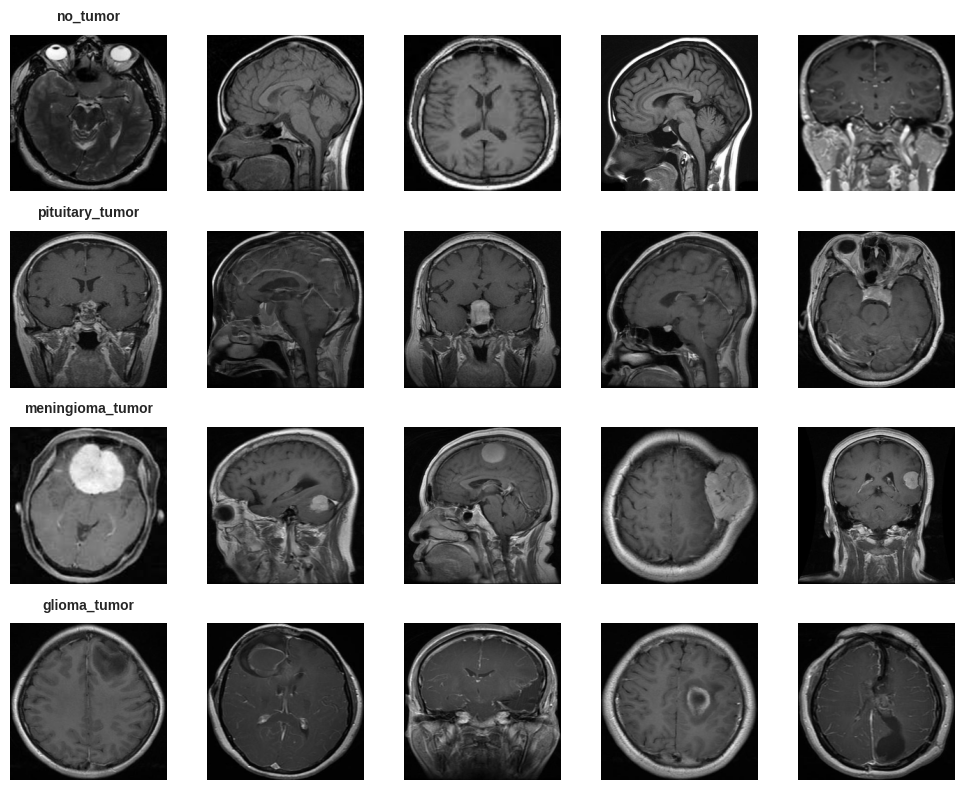

In [ ]:
# Fonction qui permet d'afficher des exemples d'images pour chaque classe aprés le prétraitement
def show_examples(X_data, Y_data, classes, num_examples=5):
    num_classes = len(classes)
    fig, axs = plt.subplots(num_classes, num_examples, figsize=(10, 8))

    for i, class_name in enumerate(classes):
        class_indices = [idx for idx, label in enumerate(Y_data) if label == i]
        axs[i, 0].set_title(class_name, fontsize=10, pad=10, fontweight='bold')
        for j in range(num_examples):
                img = X_data[class_indices[j]]
                axs[i, j].imshow(img)
                axs[i, j].axis('off')

    plt.tight_layout()
    plt.show()

# Afficher des exemples d'images pour chaque classe aprés le prétraitement
show_examples(X_train, Y_train, classes)

### Mélanger les données

In [ ]:
X_train, Y_train = shuffle(X_train,Y_train, random_state=64)

Le mélange (shuffle) des données avant de les diviser en ensembles d'entraînement et de validation est important pour garantir que le modèle ne soit pas biaisé par l'ordre initial des données (dans notre cas, toutes les données d'une classe suivies de toutes les données d'une autre classe). Sans mélange, le modèle pourrait apprendre à partir de tendances ou de corrélations spécifiques à l'ordre des données, ce qui pourrait nuire à sa généralisation sur de nouvelles données. En mélangeant les données, on s'assure que le modèle apprend de manière plus robuste et peut généraliser efficacement à de nouvelles observations.

In [ ]:
# Diviser l'ensemble d'entrainement en ensembles d'entrainement et de test
X_train,X_test,Y_train,Y_test = train_test_split(X_train,Y_train, test_size=0.3,random_state=64)

Ce code divise l'ensemble de données d'entraînement en ensembles d'entraînement et de test à l'aide de la fonction train_test_split(), avec une proportion de 90% pour l'entraînement et 20% pour le test.

In [ ]:
# Diviser l'ensemble d'entrainement en ensembles d'entrainement et de test
X_test,X_val,Y_test,Y_val = train_test_split(X_test,Y_test, test_size=2/3,random_state=64)

Ce code divise l'ensemble de données de test en ensembles de test et de validation à l'aide de la fonction train_test_split(), avec une proportion de 50% pour le test et 50% pour la validation

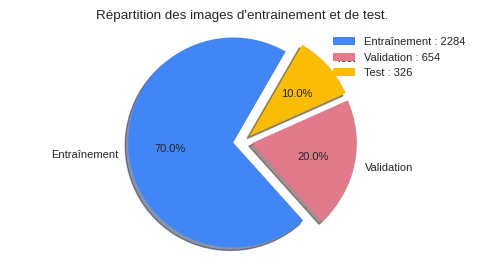

In [ ]:
sizes = [len(Y_train), len(Y_val), len(Y_test)]
labels = ['Entraînement', 'Validation', 'Test']
colors = ['#4285f4', '#E17A8A', '#fbbc05']

plt.figure(figsize=(6,3))
plt.rcParams.update({'font.size': 8})
patches, texts, autotexts = plt.pie(sizes,labels=labels,colors=colors, autopct='%.1f%%', explode=(0.1,0.08,0.08), shadow=True, startangle=60);
plt.title(f"Répartition des images d'entrainement et de test.")
plt.legend(patches, [f"{label} : {size}" for label, size in zip(labels, sizes)], loc="best")
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


## Encodage One Hot

In [ ]:
Y_train =  np.array(tensorflow.keras.utils.to_categorical(Y_train))
Y_val =  np.array(tensorflow.keras.utils.to_categorical(Y_val))
Y_test =  np.array(tensorflow.keras.utils.to_categorical(Y_test))

La méthode to_categorical() utilisée joue un rôle essentiel dans le prétraitement des étiquettes de classification pour l'apprentissage automatique. Cette méthode applique un encodage One-Hot aux étiquettes d'entraînement. Cela implique d'ajuster l'encodeur aux étiquettes pour les convertir en représentations binaires. Chaque classe est ainsi représentée par un vecteur binaire où un seul bit est activé (1) pour la classe correspondante, tandis que les autres bits sont désactivés (0). Cette transformation permet de gérer efficacement les classes catégoriques lors de problèmes de classification, garantissant que le modèle puisse traiter les étiquettes de manière appropriée lors de l'entraînement.

### Augmentation des donnees

In [ ]:
# Définir les paramètres d'augmentation des données
train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.,
    height_shift_range=0.,
    shear_range=0.2,
    zoom_range=0.05,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest'
)

In [ ]:
train_generator = train_datagen.flow(
    x=np.array(X_train),  # Les images
    y=np.array(Y_train) # Les étiquettes, converties en one-hot encoding
)

**L'augmentation des données** est une technique fondamentale en vision par ordinateur, notamment dans le domaine de l'apprentissage profond, qui consiste à générer de nouvelles données d'entraînement en appliquant des transformations aléatoires à des données existantes. Cela aide à élargir et à diversifier l'ensemble de données d'entraînement, ce qui permet au modèle d'apprendre des motifs plus robustes et généralisables.

L'augmentation des données, spécifiée dans train_datagen, comprend des transformations telles que la rotation, le cisaillement, le zoom et le retournement horizontal des images. En appliquant ces transformations de manière aléatoire aux images d'entraînement, le modèle est exposé à une variété de perspectives et de conditions, ce qui l'aide à mieux généraliser et à être plus robuste face à de nouvelles données.

### Visualisation de quelques exemples d'une image augmenté

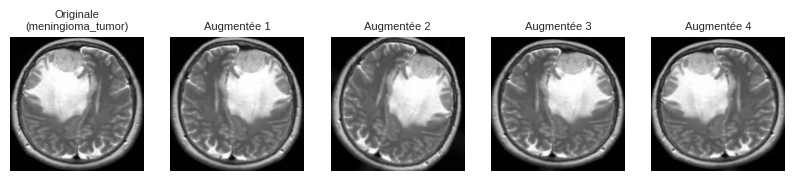

In [ ]:
#visualiser quelques exemples d'une image augmenté
random_index = np.random.randint(len(X_train))
image = X_train[random_index]
class_label_encoded = Y_train[random_index]
class_label = classes[np.argmax(class_label_encoded)]

# Display the original image
plt.figure(figsize=(10, 5))
plt.subplot(1, 5, 1)
plt.imshow(image)
plt.title('Originale\n({})'.format(class_label), fontsize=8)
plt.axis('off')

# Generate and display augmented versions of the image
for i in range(4):
    augmented_image = train_datagen.random_transform(image)
    plt.subplot(1, 5, i + 2)
    plt.imshow(augmented_image)
    plt.title('Augmentée {}'.format(i + 1), fontsize=8)
    plt.axis('off')

plt.show()

## Modelisation

In [ ]:
#le modèle CNN
CNN_model = Sequential()
CNN_model.add(Conv2D(16, (3,3), activation='relu', input_shape=shape))
CNN_model.add(MaxPooling2D(2,2))
CNN_model.add(Dropout(0.2))

CNN_model.add(Conv2D(32, (3,3), activation='relu'))
CNN_model.add(MaxPooling2D(2,2))
CNN_model.add(Dropout(0.2))

CNN_model.add(Conv2D(64, (3,3), activation='relu'))
CNN_model.add(MaxPooling2D(2,2))
CNN_model.add(Dropout(0.2))

CNN_model.add(Conv2D(128, (3,3), activation='relu'))
CNN_model.add(MaxPooling2D(2,2))
CNN_model.add(Dropout(0.2))

CNN_model.add(Conv2D(512, (3,3), activation='relu'))
CNN_model.add(MaxPooling2D(2,2))
CNN_model.add(Dropout(0.2))

CNN_model.add(Flatten())
CNN_model.add(Dense(512, activation='relu'))
CNN_model.add(Dropout(0.5))

CNN_model.add(Dense(len(classes), activation='softmax'))


# Compiler le modèle
CNN_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', Precision(), Recall()])
CNN_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 223, 223, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 111, 111, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 26, 26, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 10, 10, 512)         │         590,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 5, 5, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 5, 5, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       6,554,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,243,940 (27.63 MB)

 Trainable params: 7,243,940 (27.63 MB)

 Non-trainable params: 0 (0.00 B)

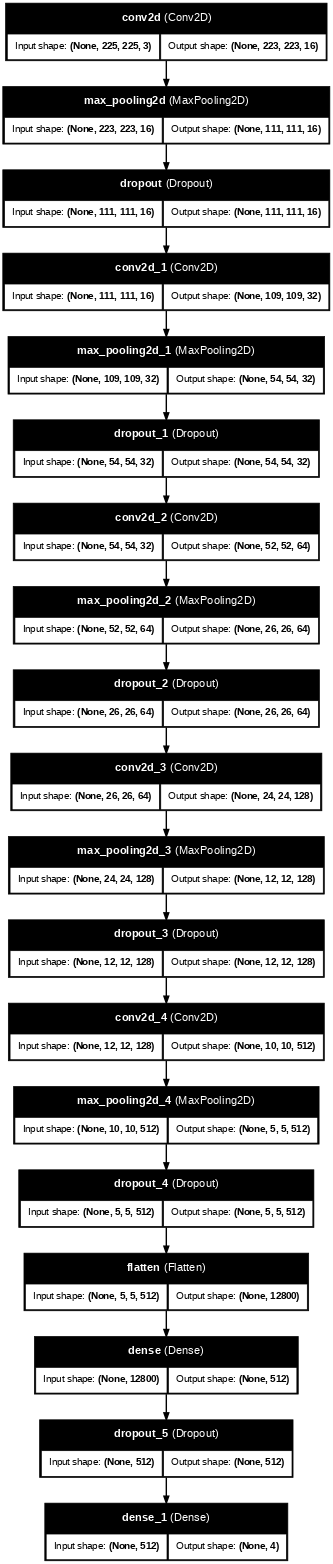

In [ ]:
tensorflow.keras.utils.plot_model(CNN_model,show_shapes=True, show_layer_names=True, dpi=50)

In [ ]:
# Définir la taille du lot
batch_size = 64
# Image shape: height, width, RBG
image_shape = shape
# le nombre d'epochs
epochs = 20 #80

print(f'Batch size: {batch_size}')
print(f'Image shape: {image_shape}')
print(f'Epochs: {epochs}')

Batch size: 64
Image shape: (225, 225, 3)
Epochs: 20


In [ ]:
# Ajouter ReduceLROnPlateau , EarlyStopping et checkpoint comme callbacks lors de l'entraînement
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=10, min_delta=0.0001, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)  #Arrête l'entraînement prématurément si la performance sur la validation ne s'améliore pas pendant un certain nombre d'époques.
checkpoint = ModelCheckpoint(filepath='best_CNNModel.keras', monitor='val_accuracy', save_best_only=True, verbose=1)  #Sauvegarde le meilleur modèle en termes de performance sur la validation.


*  **ReduceLROnPlateau**: Surveille la perte de validation (val_loss) et diminue le taux d'apprentissage (factor) si aucune amélioration n'est observée pendant un nombre donné d'époques (patience). Cela aide à stabiliser l'apprentissage lorsque le modèle se rapproche d'un minimum local et à obtenir une meilleure convergence.
* **EarlyStopping**: Surveille la perte de validation (val_loss) et arrête l'entraînement prématurément si aucune amélioration n'est observée pendant un nombre donné d'époques (patience). L'option restore_best_weights=True restaure les poids du modèle à la meilleure configuration observée lors de l'entraînement, ce qui aide à éviter le surajustement.

*   **ModelCheckpoint**: Surveille une métrique spécifique (monitor, généralement la précision de validation) et sauvegarde le modèle sous forme de fichier lorsque cette métrique s'améliore. L'option save_best_only=True garantit que seule la meilleure version du modèle est sauvegardée, ce qui est utile pour éviter de perdre des modèles prometteurs lors de l'entraînement.






In [ ]:
# Train the model
start_time = time.time()
CNN_history = CNN_model.fit(
    train_generator,
    epochs=epochs,
    batch_size=batch_size,
    validation_data = (X_val, Y_val),
    callbacks=[reduce_lr, early_stop, checkpoint],
    verbose=1
)
end_time = time.time()

Epoch 1/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - accuracy: 0.5087 - loss: 1.1019 - precision: 0.5988 - recall: 0.2374
Epoch 1: val_accuracy improved from -inf to 0.36086, saving model to best_CNNModel.keras
72/72 ━━━━━━━━━━━━━━━━━━━━ 29s 377ms/step - accuracy: 0.5085 - loss: 1.1021 - precision: 0.5987 - recall: 0.2372 - val_accuracy: 0.3609 - val_loss: 1.5620 - val_precision: 0.3988 - val_recall: 0.3043 - learning_rate: 0.0010
Epoch 2/20
71/72 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step - accuracy: 0.5327 - loss: 1.0708 - precision: 0.6065 - recall: 0.3080
Epoch 2: val_accuracy did not improve from 0.36086
72/72 ━━━━━━━━━━━━━━━━━━━━ 28s 355ms/step - accuracy: 0.5332 - loss: 1.0698 - precision: 0.6076 - recall: 0.3087 - val_accuracy: 0.3440 - val_loss: 1.5503 - val_precision: 0.3699 - val_recall: 0.2890 - learning_rate: 0.0010
Epoch 3/20
71/72 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - accuracy: 0.6020 - loss: 0.9297 - precision: 0.6973 - recall: 0.4570
Epoch 3: val_accuracy did not improve from 

## Evaluation

In [ ]:
CNN_history.history.keys()

dict_keys(['accuracy', 'loss', 'precision', 'recall', 'val_accuracy', 'val_loss', 'val_precision', 'val_recall', 'learning_rate'])

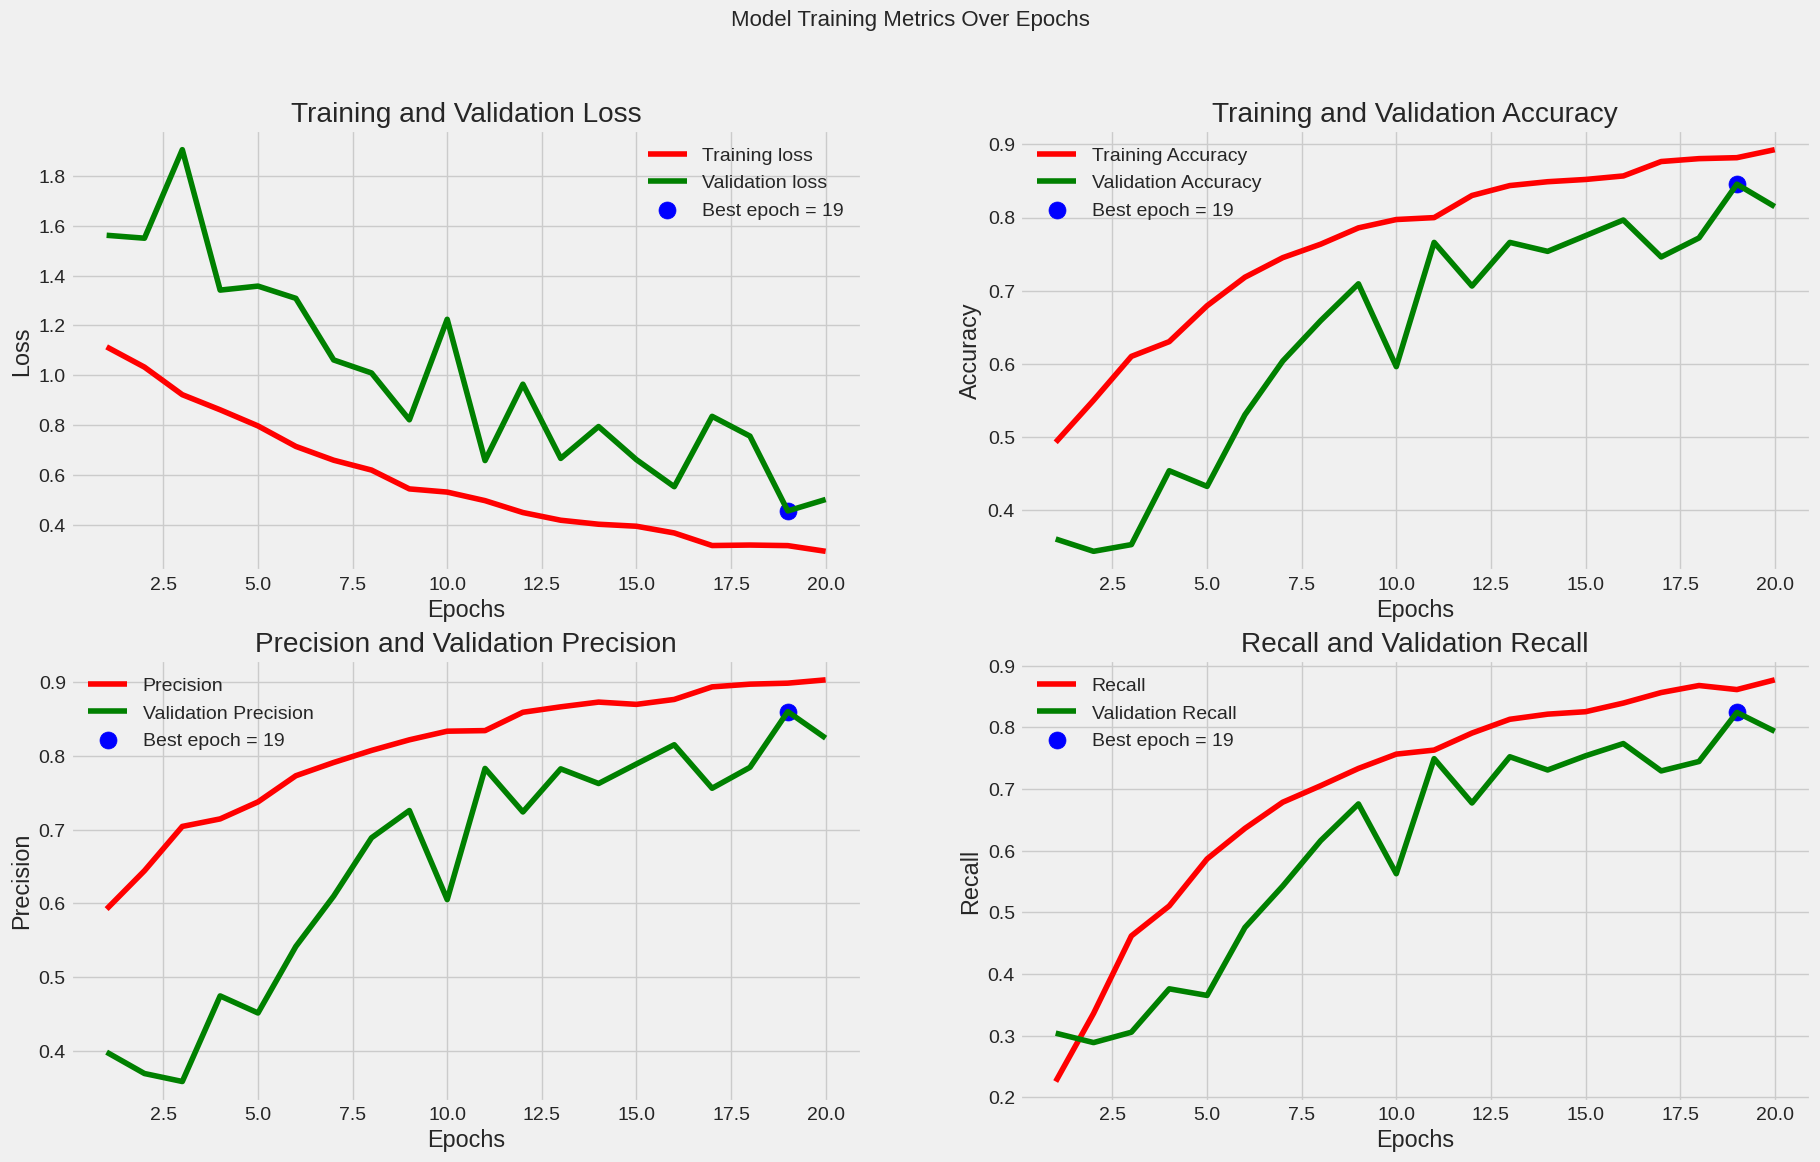

In [ ]:
tr_acc = CNN_history.history['accuracy']
tr_loss = CNN_history.history['loss']
tr_per = CNN_history.history['precision']
tr_recall = CNN_history.history['recall']
val_acc = CNN_history.history['val_accuracy']
val_loss = CNN_history.history['val_loss']
val_per = CNN_history.history['val_precision']
val_recall = CNN_history.history['val_recall']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
index_precision = np.argmax(val_per)
per_highest = val_per[index_precision]
index_recall = np.argmax(val_recall)
recall_highest = val_recall[index_recall]

Epochs = [i + 1 for i in range(len(tr_acc))]
loss_label = f'Best epoch = {str(index_loss + 1)}'
acc_label = f'Best epoch = {str(index_acc + 1)}'
per_label = f'Best epoch = {str(index_precision + 1)}'
recall_label = f'Best epoch = {str(index_recall + 1)}'


plt.figure(figsize=(20, 12))
plt.style.use('fivethirtyeight')

plt.subplot(2, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training loss')
plt.plot(Epochs, val_loss, 'g', label='Validation loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(Epochs, tr_per, 'r', label='Precision')
plt.plot(Epochs, val_per, 'g', label='Validation Precision')
plt.scatter(index_precision + 1, per_highest, s=150, c='blue', label=per_label)
plt.title('Precision and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(Epochs, tr_recall, 'r', label='Recall')
plt.plot(Epochs, val_recall, 'g', label='Validation Recall')
plt.scatter(index_recall + 1, recall_highest, s=150, c='blue', label=recall_label)
plt.title('Recall and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)

plt.suptitle('Model Training Metrics Over Epochs', fontsize=16)
plt.show()

In [ ]:
# Évaluer le modèle sur l'ensemble de Training
train_result = CNN_model.evaluate(X_train,Y_train)

# Afficher les métriques de performance
print("Train Loss: {:.2f}%".format(train_result[0] * 100))
print("Train Accuracy: {:.2f}%".format(train_result[1] * 100))
print("Train Precision: {:.2f}%".format(train_result[2] * 100))
print("Train Recall: {:.2f}%".format(train_result[3] * 100))

72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.8924 - loss: 0.2618 - precision: 0.9035 - recall: 0.8843
Train Loss: 24.54%
Train Accuracy: 90.67%
Train Precision: 91.60%
Train Recall: 89.80%


In [ ]:
# Évaluer le modèle sur l'ensemble de test
test_results = CNN_model.evaluate(X_test,Y_test)

# Afficher les métriques de performance
print("Test Loss: {:.2f}%".format(test_results[0] * 100))
print("Test Accuracy: {:.2f}%".format(test_results[1] * 100))
print("Test Precision: {:.2f}%".format(test_results[2] * 100))
print("Test Recall: {:.2f}%".format(test_results[3] * 100))

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.8148 - loss: 0.4907 - precision: 0.8304 - recall: 0.7834
Test Loss: 48.80%
Test Accuracy: 81.60%
Test Precision: 83.50%
Test Recall: 79.14%


**Loss (perte)** : La perte est une mesure de l'erreur du modèle lors de la prédiction des étiquettes par rapport aux vraies étiquettes. Elle représente essentiellement la différence entre la prédiction du modèle et la vérité terrain, et est généralement minimisée pendant l'entraînement.

**Accuracy (précision)** : L'accuracy est le pourcentage de prédictions correctes par rapport au nombre total de prédictions. Elle mesure la capacité du modèle à classifier correctement les exemples.
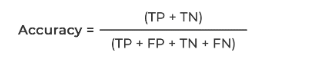
**Precision (précision)** : La précision est le nombre de vrais positifs (exemples correctement identifiés comme positifs) divisé par le nombre total de prédictions positives (vrais positifs + faux positifs). Elle indique la proportion de prédictions positives qui sont correctes.
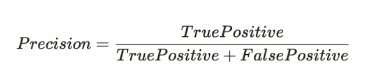
**Recall (rappel) **: Le rappel est le nombre de vrais positifs divisé par le nombre total de vrais positifs et de faux négatifs (exemples positifs manqués). Il mesure la capacité du modèle à identifier correctement tous les exemples positifs.
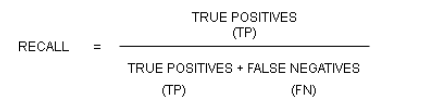
**F1 Score** : Le F1 score est la moyenne harmonique de la précision et du rappel. Il offre un compromis entre la précision et le rappel. Un F1 score élevé indique à la fois une bonne précision et un bon rappel.

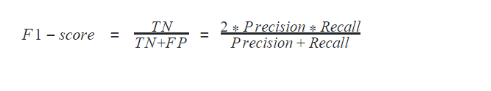


## Prediction

In [ ]:
predictions = CNN_model.predict(X_test)
y_true_test = np.argmax(Y_test, axis=1)
y_pred_test = np.argmax(predictions, axis=1)

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step


In [ ]:
accuracy = accuracy_score(y_true_test, y_pred_test)
print("Accuracy:{:.2f}%".format(accuracy * 100))

Accuracy:81.60%


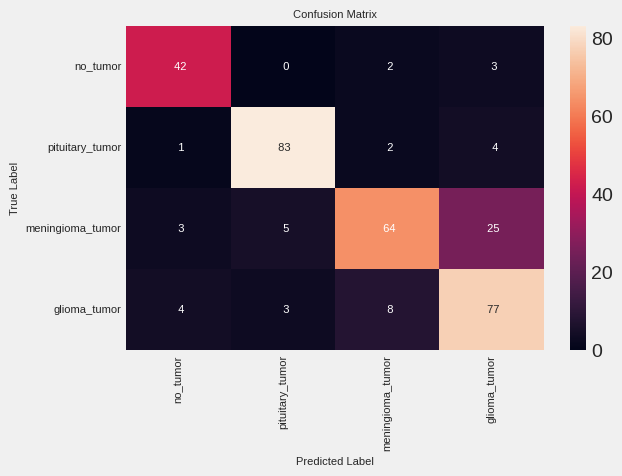

In [ ]:
plt.figure(figsize=(6, 4))
heatmap = sns.heatmap(confusion_matrix(y_true_test,y_pred_test), annot=True, fmt='3g',
                      xticklabels=classes, yticklabels=classes, annot_kws={"size": 8})

plt.title('Confusion Matrix',fontsize=8)
plt.xlabel('Predicted Label',fontsize=8)
plt.ylabel('True Label',fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()

In [ ]:
class_report = classification_report(y_true_test, y_pred_test, target_names=classes)
print("Classification Report:")
print(class_report)

Classification Report:
                  precision    recall  f1-score   support

        no_tumor       0.84      0.89      0.87        47
 pituitary_tumor       0.91      0.92      0.92        90
meningioma_tumor       0.84      0.66      0.74        97
    glioma_tumor       0.71      0.84      0.77        92

        accuracy                           0.82       326
       macro avg       0.83      0.83      0.82       326
    weighted avg       0.82      0.82      0.81       326



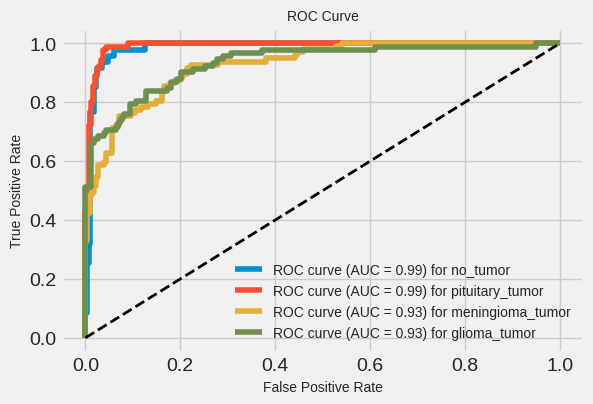

In [ ]:
# Obtenir les probabilités prédites pour chaque classe
y_pred_prob = predictions
y_true_test_OneHot = np.array(tensorflow.keras.utils.to_categorical(y_true_test))
# Calculer les courbes ROC et les aires sous la courbe pour chaque classe
fpr = dict()
tpr = dict()
roc_auc = dict()

# Calculer les courbes ROC et les aires sous la courbe pour chaque classe
plt.figure(figsize=(6,4))
for i in range(len(classes)):
    fpr, tpr, _ = roc_curve(y_true_test_OneHot[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f}) for {classes[i]}')

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Droite en pointillés représentant la performance aléatoire
plt.xlabel('False Positive Rate', fontsize=10)
plt.ylabel('True Positive Rate', fontsize=10)
plt.title('ROC Curve', fontsize=10)
plt.legend(loc='lower right', fontsize=10)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 998ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


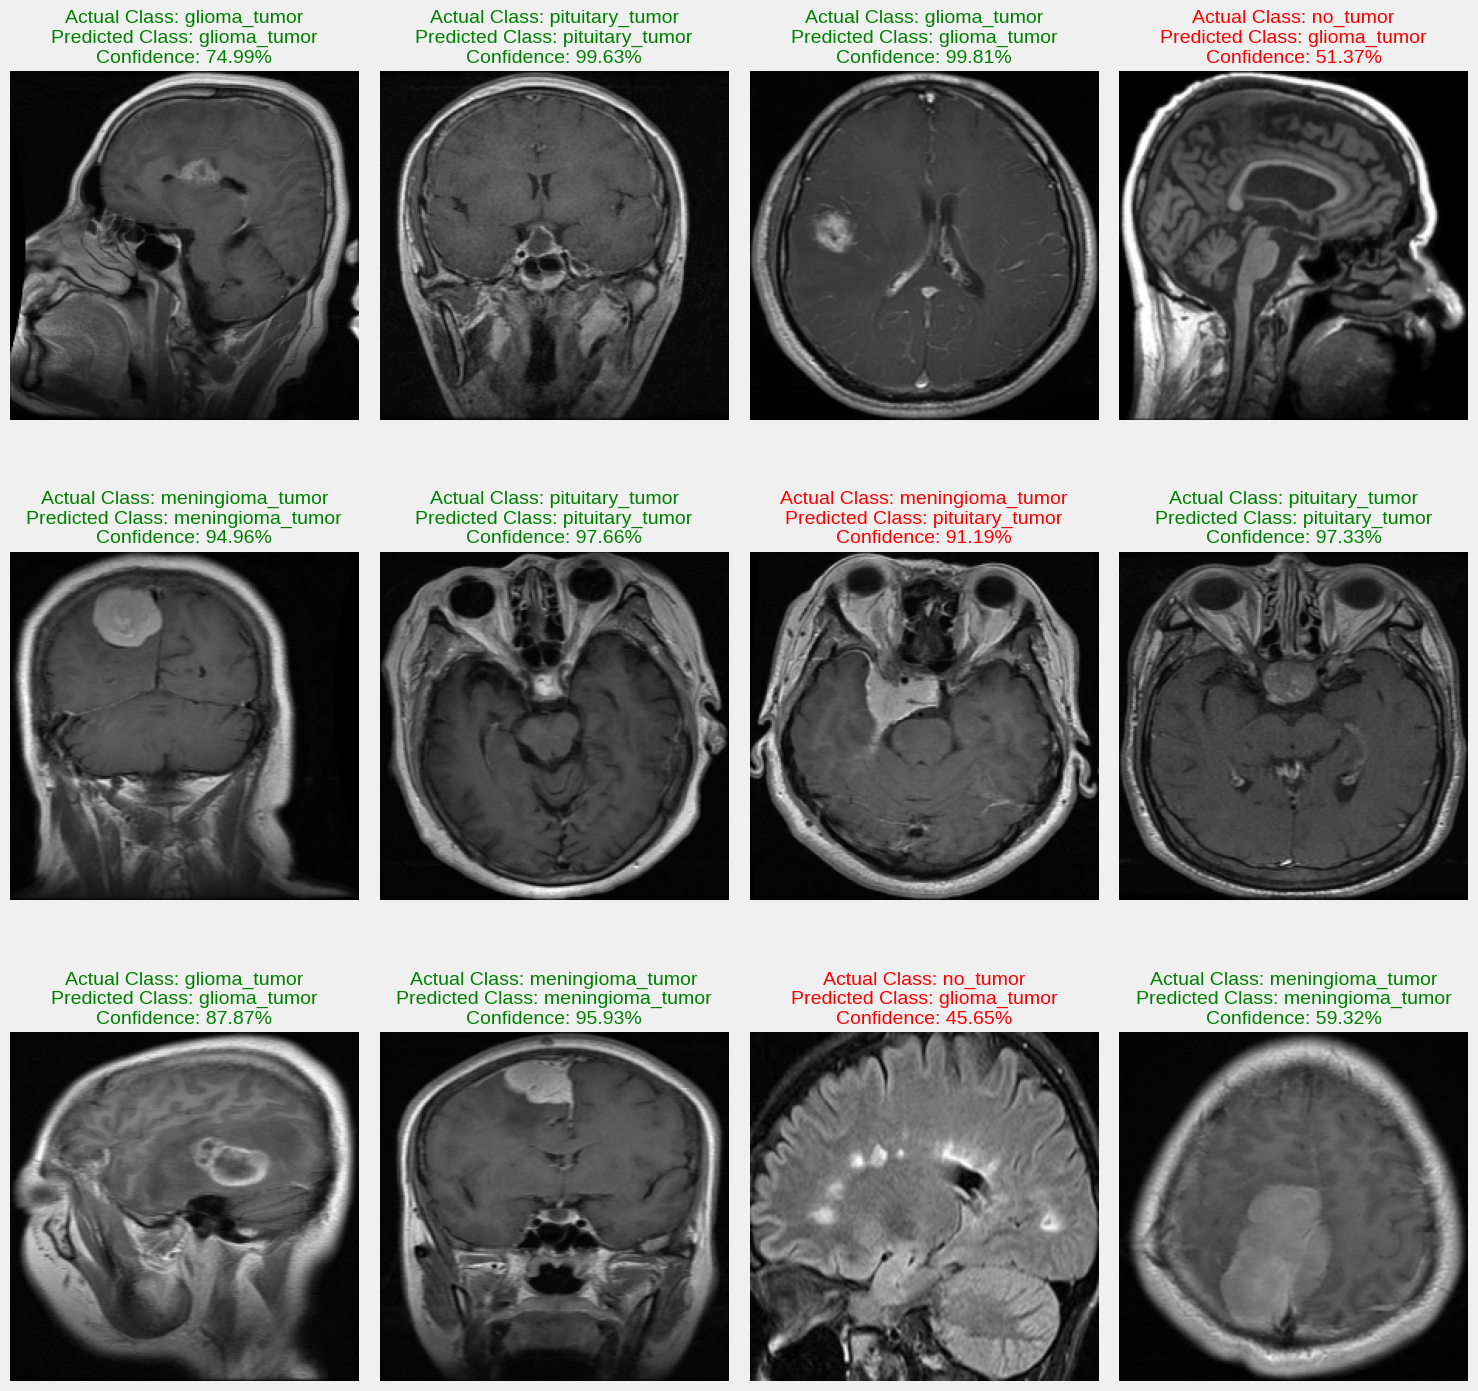

In [ ]:
indices = np.random.choice(len(Y_test), size=12, replace=False)

# Récupération des images et des étiquettes
images = X_test
Y_test = np.argmax(Y_test, axis=1)
labels = Y_test

plt.figure(figsize=(15, 15))

for i, idx in enumerate(indices):
    image = images[idx]
    true_label = classes[labels[idx]]

    # Prédiction sur l'image
    prediction = CNN_model.predict(np.expand_dims(image, axis=0))
    predicted_class = classes[np.argmax(prediction)]
    confidence = np.max(prediction) * 100

    # Détermination de la couleur du texte en fonction de la prédiction
    color = 'green' if true_label == predicted_class else 'red'
    # Affichage de l'image
    plt.subplot(3, 4, i+1)
    plt.imshow(image)
    plt.title(f"Actual Class: {true_label}\nPredicted Class: {predicted_class}\nConfidence: {confidence:.2f}%", color=color, fontsize=14)
    plt.axis('off')

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
y_test :  meningioma_tumor
y_pred :  meningioma_tumor


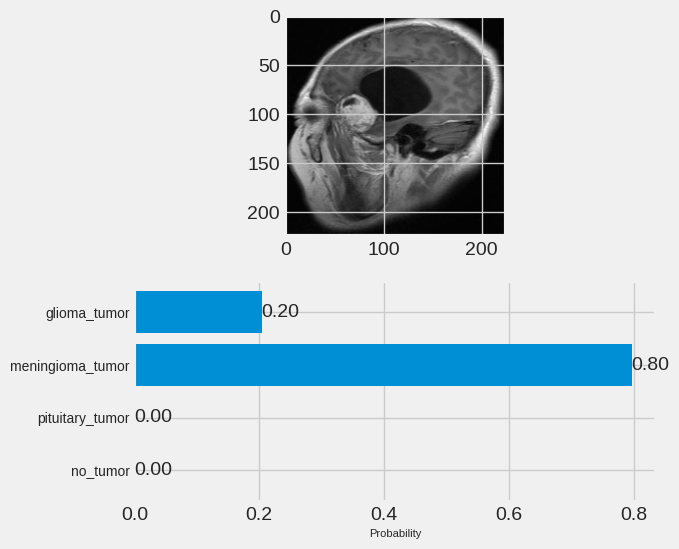

In [ ]:
plt.figure(figsize=(6, 6))
resized_img = cv2.resize(X_test[1], (shape[1], shape[0]))
img = np.asarray(resized_img)
img = np.expand_dims(img, axis=0)
img = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
predictions = CNN_model.predict(img)
print('y_test : ',classes[Y_test[1]])
y_pred = np.argmax(predictions, axis=1)
print('y_pred : ',classes[y_pred[0]])
probs = list(predictions[0])
labels = classes
plt.subplot(2, 1, 1)
plt.imshow(resized_img)
plt.subplot(2, 1, 2)
bars = plt.barh(labels, probs)
plt.xlabel('Probability', fontsize=8)
ax = plt.gca()
ax.bar_label(bars, fmt = '%.2f')
plt.yticks(fontsize=10)
plt.show()

ce projet démontre l'efficacité des réseaux de neurones convolutionnels (CNN) dans le domaine médical, en particulier pour l'analyse et le diagnostic d'images médicales. La capacité des CNN à extraire automatiquement des caractéristiques pertinentes permet d'améliorer la précision et la rapidité des diagnostics. Des optimisations et des ajustements peuvent encore être apportés pour affiner les performances du modèle.

***Merci***